In [1]:
#kerasで多クラス分類のネットワークを構築する
#moduleのimport
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import seaborn as sn
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix 
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,KNeighborsClassifier)
from sklearn.utils.testing import all_estimators
import warnings
from sklearn.metrics import classification_report
from sklearn.utils.testing import all_estimators
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score
import pytest

In [2]:
def creat_dataset(read_data, window_size):
    #データの読み込み、plot関数
    def create_values(read_data):
        #データの読み込み
        data = pd.read_csv(read_data, sep=',')
        
        #データのrssi、metreをそれぞれx、yとして定義
        x = data.rssi
        y = data.label
        
        return x, y
    
    def get_label_name(labels):
        for i in range(len(labels)):
            if labels == 'far': 
                label = 0
            elif labels == 'near': 
                label = 1
            elif labels == 'leave':
                label = 2
            elif labels == 'approach':
                label = 3
            else:
                label = 4
        return label
    
    list_X, list_Y = create_values(read_data)
    
    #Xを正の値に直して正規化
    min_ = 40
    max_ = 120
    list_X = (abs(list_X) -  min_)/ (max_ - min_)
    
    list_metre = []  #labelのlist
    list_rssi = []   #rssiのlist

    #list_Xをwindow_sizeごとにサンプリング
    for i in range(0, len(list_X) - window_size, 1):
        list_rssi.append(list_X[i:i+window_size].values)
    
    #list_Yをwindow_sizeごとにサンプリング
    for i in range(0, len(list_Y) - window_size, 1):
        list_metre.append(get_label_name(list_Y[i+window_size]))
        
    data = np.array(list_rssi)
    label = np.array(list_metre)
    
    return data, label

In [3]:
#分類器
def model(train_X, train_y, test_X, test_y, model_name):
    
    nca = NeighborhoodComponentsAnalysis(random_state=42)
    knn = KNeighborsClassifier(n_neighbors=3)
    
    if (model_name == 'SVC_linear'):
        model = {'SVC_linear': SVC(kernel='linear', random_state=0, class_weight='balanced')}
        
    elif(model_name ==  'SVC_poly'):
        model = {'SVC_poly': SVC(kernel='poly', random_state=0, class_weight='balanced')}
        
    elif(model_name ==  'SVC_rbf'):
        model = {'SVC_poly': SVC(kernel='rbf', random_state=0, class_weight='balanced')}
        
    elif(model_name ==  'SVC_sigmoid'):
        model = {'SVC_sigmoid': SVC(kernel='sigmoid', random_state=0, class_weight='balanced')}
        
    elif (model_name == 'tree'):
        model = {'tree': DecisionTreeClassifier(random_state=0, class_weight='balanced')}
    
    elif (model_name == 'AdaBoost'):
        model = {'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(random_state=0, class_weight='balanced'), random_state=0)}
    
    elif (model_name == 'Bagging'):
        model = {'Bagging': BaggingClassifier(DecisionTreeClassifier(random_state=0, class_weight='balanced'), n_estimators=100, random_state=0)}
    
    elif (model_name == 'Bagging & AdaBoost'):
        model = {'Bagging & AdaBoost': AdaBoostClassifier(BaggingClassifier(DecisionTreeClassifier(random_state=0, class_weight='balanced'),
                                                       n_estimators=100,random_state=0),
                                                       random_state=0)}
    
    elif (model_name == 'RandomForest'):
        model = {'RandomForest': RandomForestClassifier(random_state=0, class_weight='balanced')}
    
    elif (model_name == 'GradientBoost'):
        model = {'GradientBoost': GradientBoostingClassifier(random_state=0, class_weight='balanced')}
        
    elif (model_name == 'GaussianNB'):
        model = {'GaussianNB': GaussianNB()}
        
    elif (model_name == 'LogisticRegression'):
        model = {'LogisticRegression': LogisticRegression(random_state=0, class_weight='balanced')}
        
    elif (model_name == 'KNeighborsClassifier'):
        model = {'KNeighborsClassifier': KNeighborsClassifier()}
        
    elif (model_name == 'NearestCentroid'):
        model = {'NearestCentroid': NearestCentroid()}
        
    elif (model_name == 'Pipeline'):
        model = {'Pipeline': Pipeline([('nca', nca), ('knn', knn)])}
        
    elif (model_name == 'ExtraTree'):
        model = {'ExtraTree': ExtraTreeClassifier(n_estimators=1000, n_jobs=-1)}
        
    elif (model_name == 'ExtraTrees'):
        model = {'ExtraTrees': ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced')}
    
    elif (model_name == 'KNeighbors'):
        model = {'KNeighbors': KNeighborsClassifier()}
        
    elif (model_name == 'HistGradient'):
        model = {'HistGradient': HistGradientBoostingClassifier()}
  
    elif (model_name == 'Perceptron'):
        model = {'Perceptron': Perceptron(random_state=0)}
        
    elif (model_name == 'MLP'):
        model = {'MLP': MLPClassifier(alpha=1, max_iter=1000)}
    
    #MLPClassifier(alpha=1, max_iter=1000)
        
    else :
        print('model_nameが間違っています')
        
    #ExtraTreeClassifier KNeighborsClassifier
    scores = {}
    scores = {}
    for model_name, model in model.items():
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X) 
        scores[(model_name, 'train_score')] = model.score(train_X, train_y)
        scores[(model_name, 'test_score')] = model.score(test_X, test_y)
        scores[(model_name, 'difference')] = model.score(train_X, train_y) - model.score(test_X, test_y)
        scores[(model_name, 'f1')] = f1_score(test_y, pred_y, average='weighted')
    
    pred_y = model.fit(train_X, train_y).predict(test_X)#pred_yにデータの予測結果を格納
    
    cnf_mr = confusion_matrix(test_y, pred_y)
    
    train_score = model.score(train_X, train_y)
    test_score = model.score(test_X, test_y)
    
    return pd.Series(scores).unstack(), cnf_mr, pred_y, model

In [4]:
#分類器
def model_selection(train_X, train_y, test_X, test_y):
    warnings.filterwarnings('ignore') 
    
    model = {'SVC_linear': SVC(kernel='linear', random_state=0, class_weight='balanced'),
             'SVC_poly': SVC(kernel='poly', random_state=0, class_weight='balanced'),
             'SVC_rbf': SVC(kernel='rbf', random_state=0, class_weight='balanced'),
             'SVC_sigmoid': SVC(kernel='sigmoid', random_state=0, class_weight='balanced'),
             'Tree': DecisionTreeClassifier(random_state=0, class_weight='balanced'),
             'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(random_state=0, class_weight='balanced'), random_state=0),
             'Bagging': BaggingClassifier(DecisionTreeClassifier(random_state=0, class_weight='balanced'), n_estimators=100, random_state=0),
             'Bagging & AdaBoost': AdaBoostClassifier(BaggingClassifier(DecisionTreeClassifier(random_state=0, class_weight='balanced'),
                                                       n_estimators=100,random_state=0),
                                                       random_state=0),
             'RandomForest': RandomForestClassifier(random_state=0, class_weight='balanced'),
             'GradientBoost': GradientBoostingClassifier(random_state=0),
#              'GaussianNB': GaussianNB(),
             'LogisticRegression': LogisticRegression(random_state=0, class_weight='balanced'),
#              'NearestCentroid': NearestCentroid(),
             'ExtraTrees': ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced'),
#              'KNeighbors': KNeighborsClassifier(),
             'HistGradient': HistGradientBoostingClassifier(),
#              'Perceptron': Perceptron(random_state=0),   
            } 
    
                
    #f1_score(test_y, pred_y, average=None)
    scores = {}
    for model_name, model in model.items():
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X) 
        scores[(model_name, 'train_score')] = model.score(train_X, train_y)
        scores[(model_name, 'test_score')] = model.score(test_X, test_y)
        scores[(model_name, 'difference')] = model.score(train_X, train_y) - model.score(test_X, test_y)
        scores[(model_name, 'f1')] = f1_score(test_y, pred_y, average='weighted')
        
    return pd.Series(scores).unstack()

In [5]:
#分類モデル探し
def sellect_model(train_x, train_y, test_x, test_y):
    warnings.filterwarnings('ignore') 
    all = all_estimators(type_filter="classifier")
    true = 0
    i = 0
    true_name = ''
    
    #print("分類器の正解率----------------------------------")
    for (name, classifier) in all:
        if name=='ClassifierChain' or name=='MultiOutputClassifier' or name=='OneVsOneClassifier' or name=='OneVsRestClassifier' or name=='OutputCodeClassifier' or name=='VotingClassifier' or name=='NuSVC':
            continue
        clf = classifier() 
        clf.fit(train_x, train_y) 
        pred = clf.predict(test_x) 
        score = accuracy_score(test_y, pred)
        print(name,"=", score)
        if i==0:
            true=score
            i += 1
        else:
            if true<score:
                true=score
                true_name=name
                i += 1
    print(true)
    print(true_name)
    
    
    return true, true_name

In [6]:
window = 35
train_x, train_y = creat_dataset("../data/data_0", window)
test_x, test_y = creat_dataset("../data/data_1", window)
val_x, val_y = creat_dataset("../data/data_2", window)

In [7]:
sellect_model(train_x, train_y, test_x, test_y)

AdaBoostClassifier = 0.4684278350515464
BaggingClassifier = 0.8518041237113402
BernoulliNB = 0.20940721649484537
CalibratedClassifierCV = 0.8369845360824743
CheckingClassifier = 0.2757731958762887
ComplementNB = 0.4065721649484536
DecisionTreeClassifier = 0.8189432989690721
DummyClassifier = 0.23646907216494845
ExtraTreeClassifier = 0.7622422680412371
ExtraTreesClassifier = 0.8730670103092784
GaussianNB = 0.7815721649484536
GaussianProcessClassifier = 0.8724226804123711
GradientBoostingClassifier = 0.8530927835051546
HistGradientBoostingClassifier = 0.8595360824742269
KNeighborsClassifier = 0.7815721649484536
LabelPropagation = 0.7912371134020618
LabelSpreading = 0.7951030927835051
LinearDiscriminantAnalysis = 0.833118556701031
LinearSVC = 0.8311855670103093
LogisticRegression = 0.8376288659793815
LogisticRegressionCV = 0.8389175257731959
MLPClassifier = 0.8408505154639175
MultinomialNB = 0.39948453608247425
NearestCentroid = 0.7751288659793815
PassiveAggressiveClassifier = 0.663659793

(0.8730670103092784, 'ExtraTreesClassifier')

In [8]:
model_selection(train_x, train_y, test_x, test_y)

,difference,f1,test_score,train_score
AdaBoost,0.191366,0.809251,0.808634,1.000000
Bagging,0.134021,0.864544,0.865979,1.000000
Bagging & AdaBoost,0.134665,0.864105,0.865335,1.000000
ExtraTrees,0.111469,0.887800,0.888531,1.000000
GradientBoost,0.131196,0.850977,0.853093,0.984289
HistGradient,0.140464,0.857347,0.859536,1.000000
LogisticRegression,0.014486,0.831593,0.833119,0.847604
RandomForest,0.123116,0.870597,0.871778,0.994894
SVC_linear,-0.008053,0.862747,0.864691,0.856638
SVC_poly,-0.073830,0.624331,0.681057,0.607227


In [9]:
show, cm, pred_y, model = model(train_x, train_y, test_x, test_y, 'HistGradient')
show

,difference,f1,test_score,train_score
HistGradient,0.140464,0.857347,0.859536,1.0


In [10]:
def print_cmx(y_true, y_pred, label, title, class_num):
    labels = label
    cmx_data = confusion_matrix(y_true, y_pred)
    
    cmx_data = cmx_data.astype('float') / cmx_data.sum(axis=1)[:, np.newaxis]
    
    cmx_data = cmx_data.round(2)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    plt.figure(figsize = (20,20))
    sn.heatmap(df_cmx, annot=True, fmt='g', square = True, cmap='Reds', vmin=0.0, vmax=1.0)
    sn.set_context('poster')
    
    plt.ylim(class_num, 0)
    plt.ylabel('True Label', fontsize=20)
    plt.xlabel('Prediction Label', fontsize=20)
    plt.title(title, fontsize=30)
    
    plt.show()

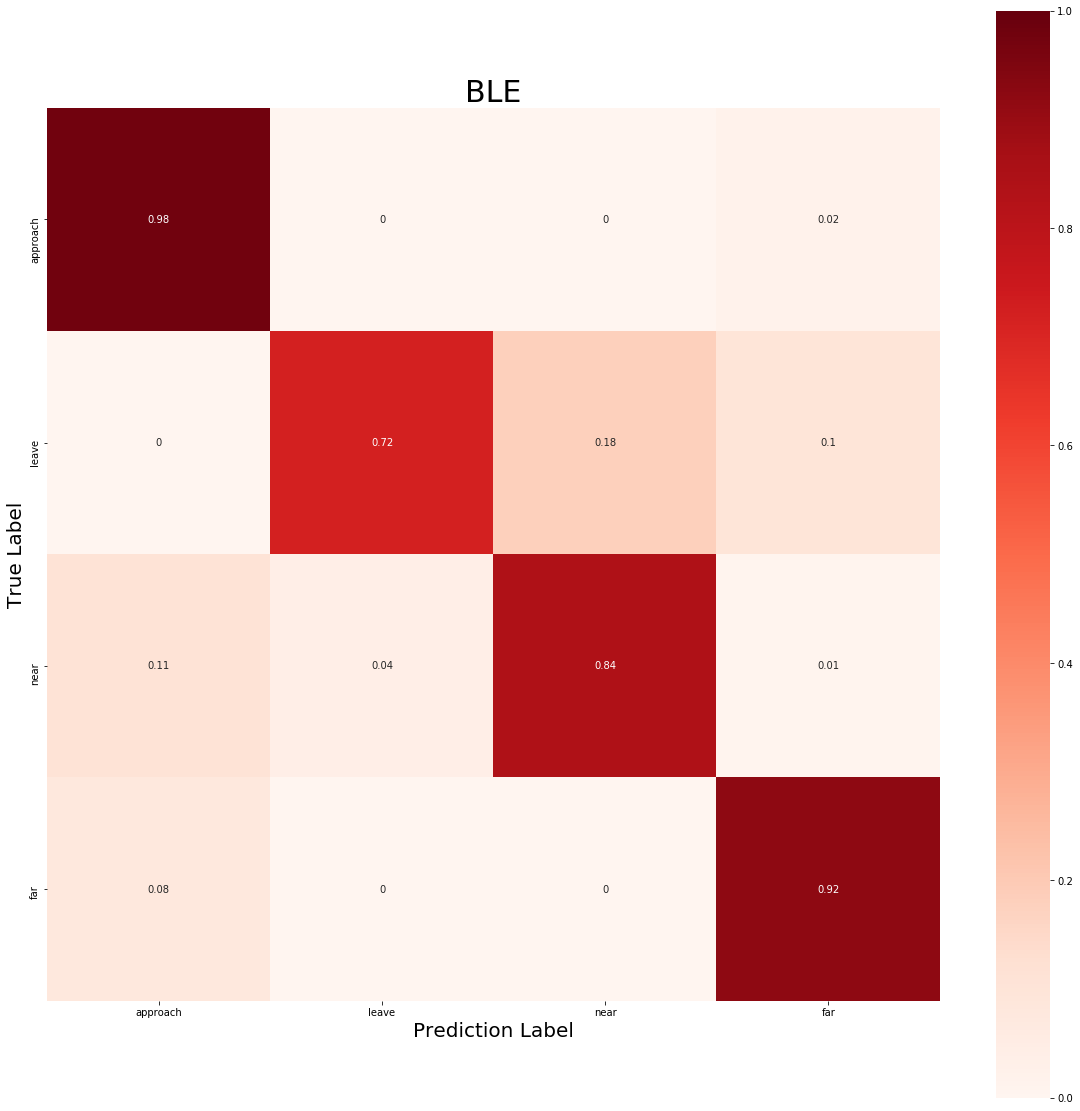

In [11]:
predict_classes = pred_y
true_classes = test_y
title = 'BLE'
class_num = 4
print_cmx(true_classes, predict_classes, ['approach', 'leave', 'near', 'far'], title, class_num)

In [12]:
from sklearn.metrics import precision_recall_fscore_support

x=precision_recall_fscore_support(list_metre_test,pred_y)

data = {"適合率": list(x[0]),
        "再現率":list(x[1]),
        "F値":list(x[2]),
       "データ数":list(x[3])}
df = pd.DataFrame(data)
df.index=["approach","leave","near","far"]
df

NameError: name 'list_metre_test' is not defined